In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns




In [31]:
combined_stats = pd.read_csv('Data/2025FantasyFootballProjections.csv')

In [33]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthGrades,2023HealthGrades2,2023Cmp,2023Att,...,2025Int,2025RushAtt,2025RushYds,2025RushTD,2025Rec,2025RecYds,2025RecTD,2025FL,2025TD,2025PPR
0,1,Josh Allen,BUF,QB,27,17,0,Healthy,385,579,...,6,113.0,561,10,0,0,0,2,41,431.3
1,2,Christian McCaffrey,SF,RB,27,16,0,Healthy,0,0,...,0,217.0,1072,7,64,611,4,2,11,292.6
2,3,CeeDee Lamb,DAL,WR/TE,24,17,0,Healthy,0,0,...,0,14.0,75,0,113,1387,8,1,8,304.6
3,4,Jalen Hurts,PHI,QB,25,17,0,Healthy,352,538,...,9,165.0,754,12,0,0,0,4,40,422.8
4,5,Tyreek Hill,MIA,WR/TE,29,16,0,Healthy,0,0,...,0,8.0,47,0,92,1161,8,0,8,261.0


In [35]:
combined_stats.groupby('FantPos')['2025PPR'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,283.415789,120.582468,15.7,270.55,315.30,356.35,450.0
RB,89.0,141.832584,80.899598,35.3,82.30,125.80,190.40,316.9
WR/TE,154.0,164.865584,62.826166,0.0,126.60,146.85,195.70,367.1


In [37]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           281 non-null    int64  
 1   Player                       281 non-null    object 
 2   Tm                           281 non-null    object 
 3   FantPos                      281 non-null    object 
 4   2023Age                      281 non-null    int64  
 5   2023G                        281 non-null    int64  
 6   2023HealthGrades             281 non-null    int64  
 7   2023HealthGrades2            281 non-null    object 
 8   2023Cmp                      281 non-null    int64  
 9   2023Att                      281 non-null    int64  
 10  2023PassYds                  281 non-null    int64  
 11  2023PassTD                   281 non-null    int64  
 12  2023Int                      281 non-null    int64  
 13  2023RushAtt         

In [39]:
# Convert columns to numeric, handling errors
numeric_columns = [
    '2024PassYds', '2024RushYds', '2024RecYds'
]

In [41]:
for col in numeric_columns:
    combined_stats[col] = pd.to_numeric(combined_stats[col], errors='coerce')

## Evaluate data using Train, Test, and Split with Random Forest Regressor.

In [44]:
# Function to train and predict for a specific position
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

        
      # Prepare X and y
    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Label split using true indices
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'
    
    # Train the model
    rf = RandomForestRegressor(
        n_estimators=200, 
        max_depth=20, 
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions only for the correct subset
    train_df = position_data.loc[idx_train, ['Player', 'FantPos', '2025PPR']].copy()
    train_df.loc[:, 'Data Split'] = 'Train'
    train_df.loc[:, 'Predicted Fantasy Points'] = y_pred_train

    test_df = position_data.loc[idx_test, ['Player', 'FantPos', '2025PPR']].copy()
    test_df.loc[:, 'Data Split'] = 'Test'
    test_df.loc[:, 'Predicted Fantasy Points'] = y_pred_test

    return pd.concat([train_df, test_df], ignore_index=True)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'Predicted Fantasy Points'] = rf.predict(X)
    
    return position_data[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
wrte_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
# te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']



# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict('RB', rb_features)
wrte_predictions = train_and_predict('WR/TE', wr_features)
# te_predictions = train_and_predict('TE', te_features)
qb_predictions = train_and_predict('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(2)

override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_RFR.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Training MAE: 11.815091968477523
RB - Testing MAE: 29.017624801587285

RB - Feature Importances:
          Feature  Importance
7     2024RushAtt    0.375938
9      2024RushTD    0.252252
17  ProjectedRole    0.100567
11     2024RecYds    0.097164
10        2024Rec    0.052836
8     2024RushYds    0.020667
12      2024RecTD    0.015608
4       2023RecTD    0.013476
16   AdjustedRisk    0.010609
15        2025Age    0.010151
3         2023Rec    0.009067
1     2023RushYds    0.008142
13         2024FL    0.007182
6          2023TD    0.006463
5          2023FL    0.006098
14    HealthGrade    0.005132
0     2023RushAtt    0.005049
2      2023RushTD    0.003598

WR/TE - Training MAE: 10.031535450028759
WR/TE - Testing MAE: 34.849947710980786

WR/TE - Feature Importances:
          Feature  Importance
10        2024Rec    0.693312
11     2024RecYds    0.057102
12      2024RecTD    0.052546
3         2023Rec    0.051817
15        2025Age    0.018777
17  ProjectedRole    0.016783
8    

In [46]:

# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.898  15.29
1    WR/TE  0.875  14.66
2       QB  0.823  28.03


In [48]:
# Evaluate R² and MAE by position (testing data only)
# Start with an empty Python list
position_metrics = []

# Filter for test data only
test_only = all_predictions[all_predictions['Data Split'] == 'Test']

for pos in test_only['FantPos'].unique():
    subset = test_only[test_only['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position: (Testing)")
print(position_metrics_df)


Performance Metrics by Position: (Testing)
  Position     R²    MAE
0       RB  0.577  29.02
1    WR/TE  0.271  34.85
2       QB -0.124  70.78


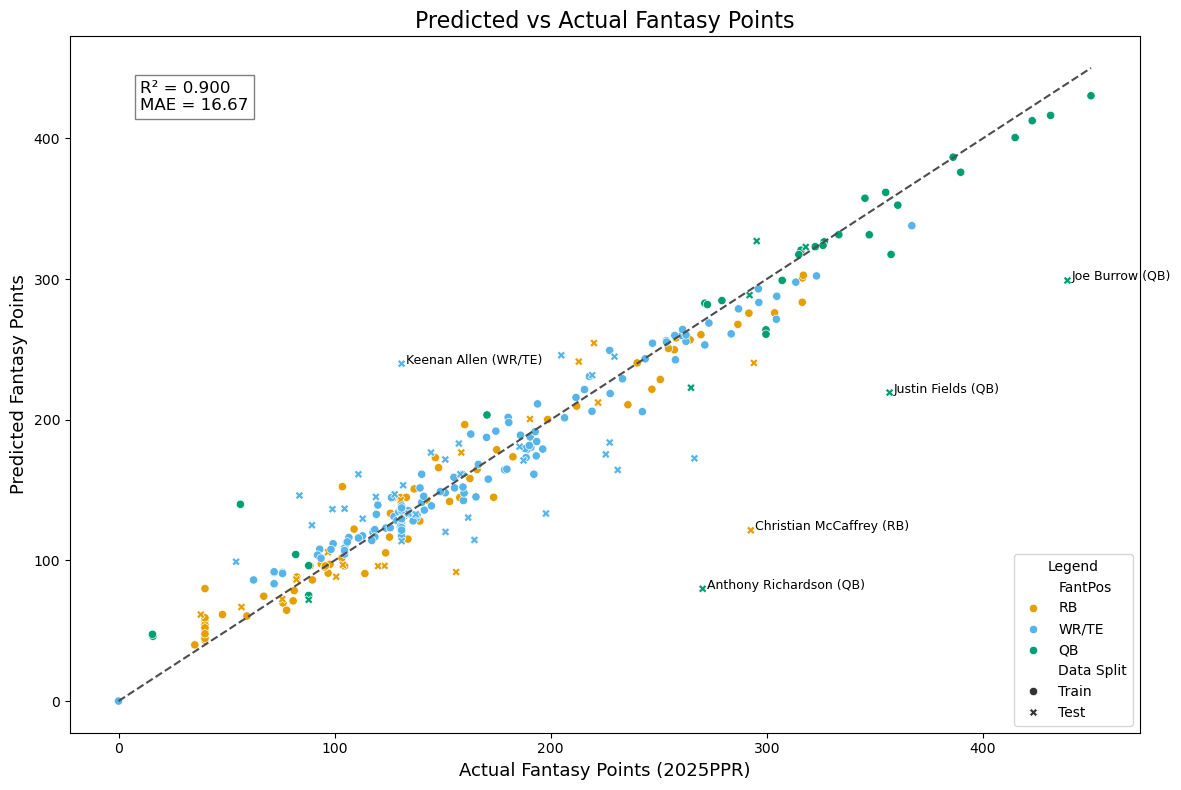

In [54]:

# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility

color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'TE': '#F0E442',   # yellow
    'QB': '#009E73',  # green
}
# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=all_predictions,
    x='2025PPR', y='Predicted Fantasy Points',
    hue='FantPos', style='Data Split',
    palette=color_palette
)

# Diagonal line for the predictions
min_val = all_predictions['2025PPR'].min()
max_val = all_predictions['2025PPR'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual Fantasy Points', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Show R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

In [77]:
all_predictions['ValuationDiff'] = all_predictions['Predicted Fantasy Points'] - all_predictions['2025PPR']

In [81]:
# Top 10 overvalued players (Predicted > Actual)
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)

print("Most Overvalued Fantasy Players:")
print(overvalued[['Player', 'FantPos', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Overvalued Fantasy Players:
                 Player FantPos  2025PPR  Predicted Fantasy Points  \
39         Daniel Jones      QB     56.4                    247.97   
137          Sam Howell      QB     15.7                    146.76   
181     Aidan O'Connell      QB     15.9                    133.00   
48         Keenan Allen   WR/TE    131.0                    244.38   
175         Rico Dowdle      RB    103.6                    210.25   
280        Tyler Shough      QB    170.5                    269.47   
72         Kirk Cousins      QB     82.0                    171.85   
171  Alexander Mattison      RB     40.0                    127.17   
37           Will Levis      QB     88.0                    172.20   
26   Travis Etienne Jr.      RB    125.8                    198.28   

     ValuationDiff  
39          191.57  
137         131.06  
181         117.10  
48          113.38  
175         106.65  
280          98.97  
72           89.85  
171          87.17  
37     

## Now we will use Cross Validation to determine the fantasy football projected scores without the 2025 projected data.

In [68]:
# Function to train and predict for a specific position using cross-validation

def train_and_predict_cv(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Adjust number of folds based on data size
    n_samples = len(position_data)
    if n_samples < 50:
        n_splits = 3
    else:
        n_splits = 5
    # "The QB model used 3-fold cross-validation due to smaller sample size (~38 QBs). 
    # This means results may carry higher variance and should be interpreted cautiously."

    # Initialize the model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)

    # Cross-validation strategy
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Get out-of-fold predictions (no leakage)
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Calculate CV MAE
    mae = mean_absolute_error(y, y_pred)
    print(f"\n{position} - Cross-Validated MAE: {mae:.2f}")

    # Fit the model on the full dataset to get final feature importances
    rf.fit(X, y)
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions
    position_data['Data Split'] = 'CrossVal'
    position_data['Predicted Fantasy Points'] = y_pred

    return position_data[['Player', 'FantPos', 'Predicted Fantasy Points', '2025PPR']]

# Define feature sets for each position, including past PPR points and new features
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', 
               '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
wrte_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds',
                 '2024RecTD', '2024FL', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']
# te_features = ['2023Rec', '2023RecTD', '2023FL', '2023TD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']
qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD', '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD', 'HealthGrade', '2025Age', 'AdjustedRisk', 'ProjectedRole']

# Train and predict for each position, excluding QBs
rb_predictions = train_and_predict_cv('RB', rb_features)
wrte_predictions = train_and_predict_cv('WR/TE', wr_features)
# te_predictions = train_and_predict_cv('TE', te_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(2)

override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/FantasyFootballPrediction_CV.csv"
all_predictions[['Player', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Cross-Validated MAE: 29.97

RB - Feature Importances:
          Feature  Importance
7     2024RushAtt    0.304204
17  ProjectedRole    0.262749
9      2024RushTD    0.160295
11     2024RecYds    0.073235
10        2024Rec    0.026855
1     2023RushYds    0.026223
8     2024RushYds    0.019202
6          2023TD    0.017491
12      2024RecTD    0.014660
3         2023Rec    0.014158
16   AdjustedRisk    0.013454
4       2023RecTD    0.013282
2      2023RushTD    0.012577
15        2025Age    0.011167
14    HealthGrade    0.010055
0     2023RushAtt    0.008925
13         2024FL    0.006573
5          2023FL    0.004896

WR/TE - Cross-Validated MAE: 27.27

WR/TE - Feature Importances:
             Feature  Importance
10           2024Rec    0.622498
11        2024RecYds    0.092700
3            2023Rec    0.079138
12         2024RecTD    0.038495
15           2025Age    0.023675
17  2025HealthGrades    0.022704
16  2024HealthGrades    0.020458
14       HealthGrade    0.019783
1      

In [70]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.743  29.97
1    WR/TE  0.708  26.18
2       QB  0.571  59.90


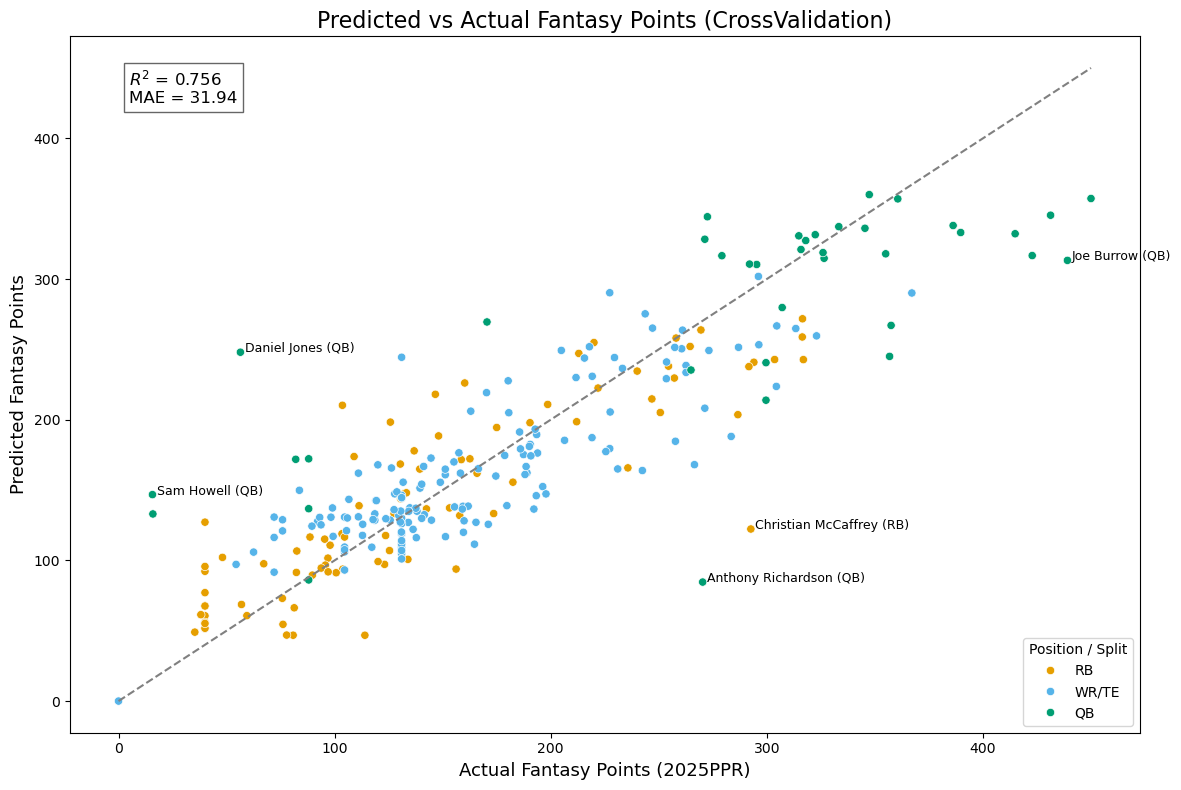

In [72]:

# Calculate metrics
r2 = r2_score(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])
mae = mean_absolute_error(all_predictions['2025PPR'], all_predictions['Predicted Fantasy Points'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['2025PPR'] - all_predictions['Predicted Fantasy Points'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'TE': '#F0E442',  # yellow
    'QB': '#009E73',  # green 
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['2025PPR'].min(), all_predictions['Predicted Fantasy Points'].min())
max_val = max(all_predictions['2025PPR'].max(), all_predictions['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['2025PPR'] + 2, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (CrossValidation)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position / Split', loc='lower right')
plt.tight_layout()
plt.show()

## Combined CV + Full-Training Prediction Function

* Combined version of train_and_predict_cv function that:
* Uses cross_val_predict to evaluate out-of-fold performance (for realistic MAE).
* Fits a final model on the full data to generate actual predicted fantasy points (for production use).
* Returns both the evaluation metrics and full-data predictions.

In [93]:
def train_and_predict_cv_ft(position, features):
    # Filter data for the specific position
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0)
    y = position_data['2025PPR'].fillna(0)

    # Initialize model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, max_features='sqrt', min_samples_split=2, random_state=42)

    # Adjust number of folds based on data size
    n_samples = len(position_data)
    if n_samples < 50:
        n_splits = 3
    else:
        n_splits = 5
    # "The QB model used 3-fold cross-validation due to smaller sample size (~38 QBs). 
    # This means results may carry higher variance and should be interpreted cautiously."

    # Cross-validation strategy
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Step 1: Cross-validated prediction
    y_pred_cv = cross_val_predict(rf, X, y, cv=kf)
    mae_cv = mean_absolute_error(y, y_pred_cv)
    print(f"\n{position} - Cross-Validated MAE (unseen): {mae_cv:.2f}")

    # Step 2: Final model trained on all data
    rf.fit(X, y)
    y_pred_final = rf.predict(X)

    # Feature importances
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Create output DataFrame
    cv_df = position_data.copy()
    cv_df['Predicted Fantasy Points'] = np.round(y_pred_cv, 2)
    cv_df['Data Split'] = 'CrossVal'
    
    ft_df = position_data.copy()
    ft_df['Predicted Fantasy Points'] = np.round(y_pred_final, 2)
    ft_df['Data Split'] = 'FullTrain'

    # Combine CV and FT predictions
    combined_df = pd.concat([cv_df, ft_df], ignore_index=True)
    
    return combined_df[['Player', 'FantPos', 'Data Split', 'Predicted Fantasy Points', '2025PPR']]


# Define feature sets for each position
rb_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD', '2024RushAtt', '2024RushYds', 
               '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL', 'HealthGrade', '2025Age', '2024HealthGrades',
               '2025HealthGrades']

wrte_features = ['2023RushAtt', '2023RushYds', '2023RushTD', '2023Rec', '2023RecTD', '2023FL', '2023TD',
               '2024RushAtt', '2024RushYds', '2024RushTD', '2024Rec', '2024RecYds', '2024RecTD', '2024FL',
               'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']

qb_features = ['2023PassYds', '2023PassTD', '2023RushYds', '2023RushTD', '2023FL', '2023TD',
               '2024RushYds', '2024RushTD', '2024FL', '2024PassYds', '2024PassTD',
               'HealthGrade', '2025Age', '2024HealthGrades', '2025HealthGrades']

# Train and predict for each position
rb_predictions = train_and_predict_cv_ft('RB', rb_features)
wrte_predictions = train_and_predict_cv_ft('WR/TE', wr_features)
# te_predictions = train_and_predict_cv_ft('TE', te_features)
qb_predictions = train_and_predict_cv_ft('QB', qb_features)

# Combine all predictions
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions])

# Initialize Note column
all_predictions['Note'] = ''

# Manual overrides (e.g., injury status)
override_dict = {
    'Tank Dell': {'points': 0, 'note': 'Out for season'},
}

for player, override in override_dict.items():
    all_predictions.loc[all_predictions['Player'] == player, 'Predicted Fantasy Points'] = override['points']
    all_predictions.loc[all_predictions['Player'] == player, 'Note'] = override['note']

# Create side-by-side comparison
side_by_side = all_predictions.pivot_table(
    index=['Player', 'FantPos', '2025PPR'],
    columns='Data Split',
    values='Predicted Fantasy Points'
).reset_index()

# Rename columns for clarity
side_by_side.columns = ['Player', 'FantPos', '2025PPR', 'Predicted Fantasy Points (CV)', 'Predicted Fantasy Points (FT)']

# Sort by FantPos (ascending) and 2025PPR (descending)
side_by_side = side_by_side.sort_values(by=['FantPos', '2025PPR'], ascending=[True, False])

# Calculate residuals
side_by_side['Residual_CV'] = (side_by_side['Predicted Fantasy Points (CV)'] - side_by_side['2025PPR']).round(1)
side_by_side['Residual_FT'] = (side_by_side['Predicted Fantasy Points (FT)'] - side_by_side['2025PPR']).round(1)

# Save results
# all_predictions[['Player', 'FantPos', 'Data Split', 'Predicted Fantasy Points', '2025PPR', 'Note']].to_csv(
#    "Data/FantasyFootballPrediction_CVFT.csv", index=False)
side_by_side.to_csv("Data/FantasyFootballPrediction_CVFT_SideBySide.csv", index=False)

# Save final predictions to CSV
# output_path = "Data/FantasyFootballPrediction_CVFT.csv"
# all_predictions[['Player', 'Data Split', 'FantPos', 'Predicted Fantasy Points', '2025PPR']].to_csv(output_path, index=False)


RB - Cross-Validated MAE (unseen): 33.16

RB - Feature Importances:
             Feature  Importance
7        2024RushAtt    0.227929
9         2024RushTD    0.172434
11        2024RecYds    0.112658
10           2024Rec    0.082461
6             2023TD    0.064628
1        2023RushYds    0.063775
2         2023RushTD    0.046915
8        2024RushYds    0.043703
0        2023RushAtt    0.041119
3            2023Rec    0.030035
12         2024RecTD    0.023198
15           2025Age    0.023175
4          2023RecTD    0.018974
13            2024FL    0.016396
14       HealthGrade    0.013676
16  2024HealthGrades    0.012168
5             2023FL    0.006756
17  2025HealthGrades    0.000000

WR/TE - Cross-Validated MAE (unseen): 25.92

WR/TE - Feature Importances:
             Feature  Importance
10           2024Rec    0.296172
11        2024RecYds    0.141540
12         2024RecTD    0.108494
3            2023Rec    0.107488
4          2023RecTD    0.044036
6             2023TD    0.04189

* Predicted Fantasy Points (CV): The out-of-fold predictions generated during cross-validation. These simulate how the model would perform on unseen data, giving a more realistic estimate of prediction error.

* Predicted Fantasy Points (Final Model): The predictions made by a model trained on all available data. These are typically more accurate but can be overly optimistic, since the model has seen the full dataset (including each player).

* Predicted Fantasy Points: This is a copy of the Final Model predictions, used as the main output for projections (e.g., fantasy draft prep). It allows for consistent overrides and output formatting.

* 2025PPR: The actual fantasy points scored by the player in 2025. This is used for error analysis and to evaluate model accuracy after the season.

* Use Predicted Fantasy Points (CV) to evaluate the model's real-world accuracy (MAE, scatterplots, etc.), and use Predicted Fantasy Points (Final Model) or Predicted Fantasy Points for forward-looking projections such as rankings and drafting.

* In most real-world ML pipelines: Use cross-validation to evaluate the model's generalization. Then, train the final model on all data to deploy/predict.

In [96]:
# Filter only CV rows
cv_only = all_predictions[all_predictions['Data Split'] == 'CrossVal']

# Evaluate R² and MAE by position using only CV data
position_metrics = []

for pos in cv_only['FantPos'].unique():
    subset = cv_only[cv_only['FantPos'] == pos]
    r2 = r2_score(subset['2025PPR'], subset['Predicted Fantasy Points'])
    mae = mean_absolute_error(subset['2025PPR'], subset['Predicted Fantasy Points'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

position_metrics_df = pd.DataFrame(position_metrics)

print("\nCV-Only Performance Metrics by Position:")
print(position_metrics_df)


CV-Only Performance Metrics by Position:
  Position     R²    MAE
0       RB  0.719  33.16
1    WR/TE  0.726  24.81
2       QB  0.226  78.68


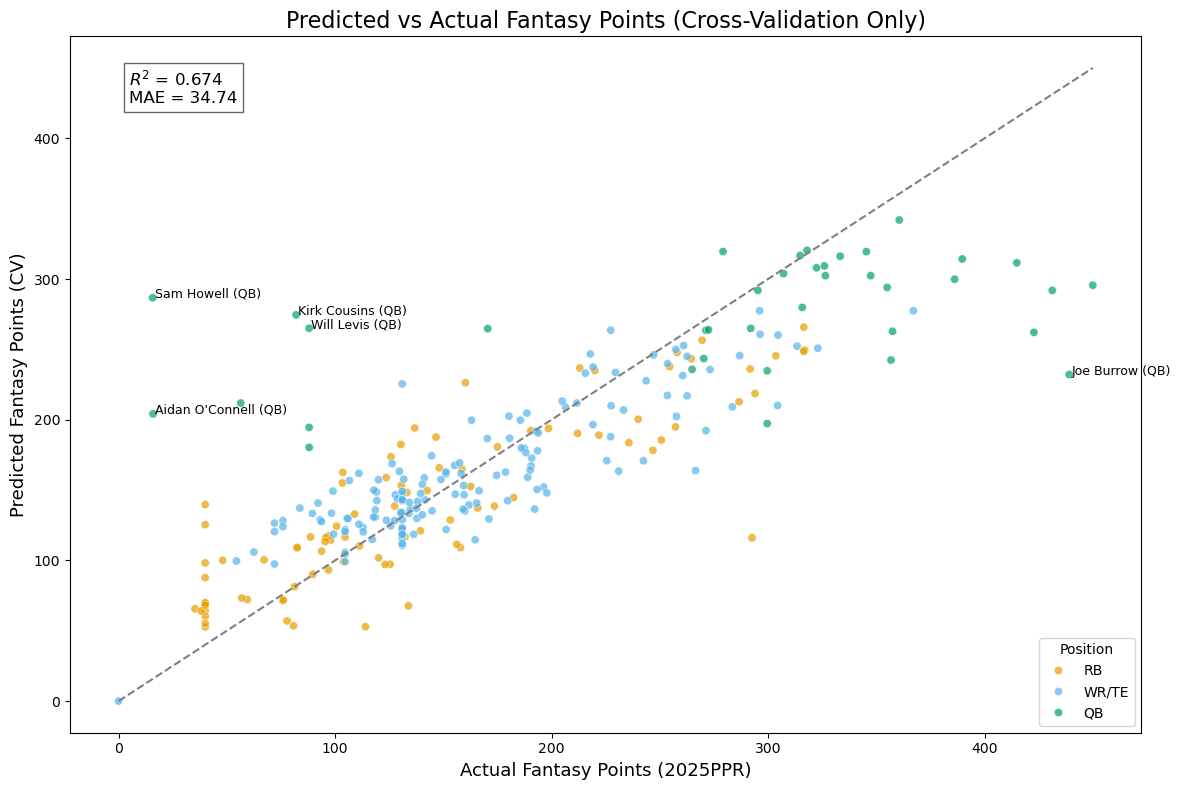

In [98]:
# Filter for CV-only data
cv_only = all_predictions[all_predictions['Data Split'] == 'CrossVal'].copy()

# Calculate CV metrics
r2_cv = r2_score(cv_only['2025PPR'], cv_only['Predicted Fantasy Points'])
mae_cv = mean_absolute_error(cv_only['2025PPR'], cv_only['Predicted Fantasy Points'])

# Calculate residuals
cv_only['Residual_CV'] = np.abs(cv_only['2025PPR'] - cv_only['Predicted Fantasy Points'])

# Get top 5 residual outliers
top_outliers_cv = cv_only.nlargest(5, 'Residual_CV')

# Colorblind-friendly palette for fantasy positions
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'TE': '#F0E442',   # yellow
    'QB': '#009E73',  # green
}

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=cv_only,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette,
    alpha=0.7
)

# Diagonal reference line
min_val = min(cv_only['2025PPR'].min(), cv_only['Predicted Fantasy Points'].min())
max_val = max(cv_only['2025PPR'].max(), cv_only['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top 5 outliers
for _, row in top_outliers_cv.iterrows():
    plt.text(row['2025PPR'] + 1, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (Cross-Validation Only)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points (CV)', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2_cv:.3f}\nMAE = {mae_cv:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='Position', loc='lower right')
plt.tight_layout()
plt.show()

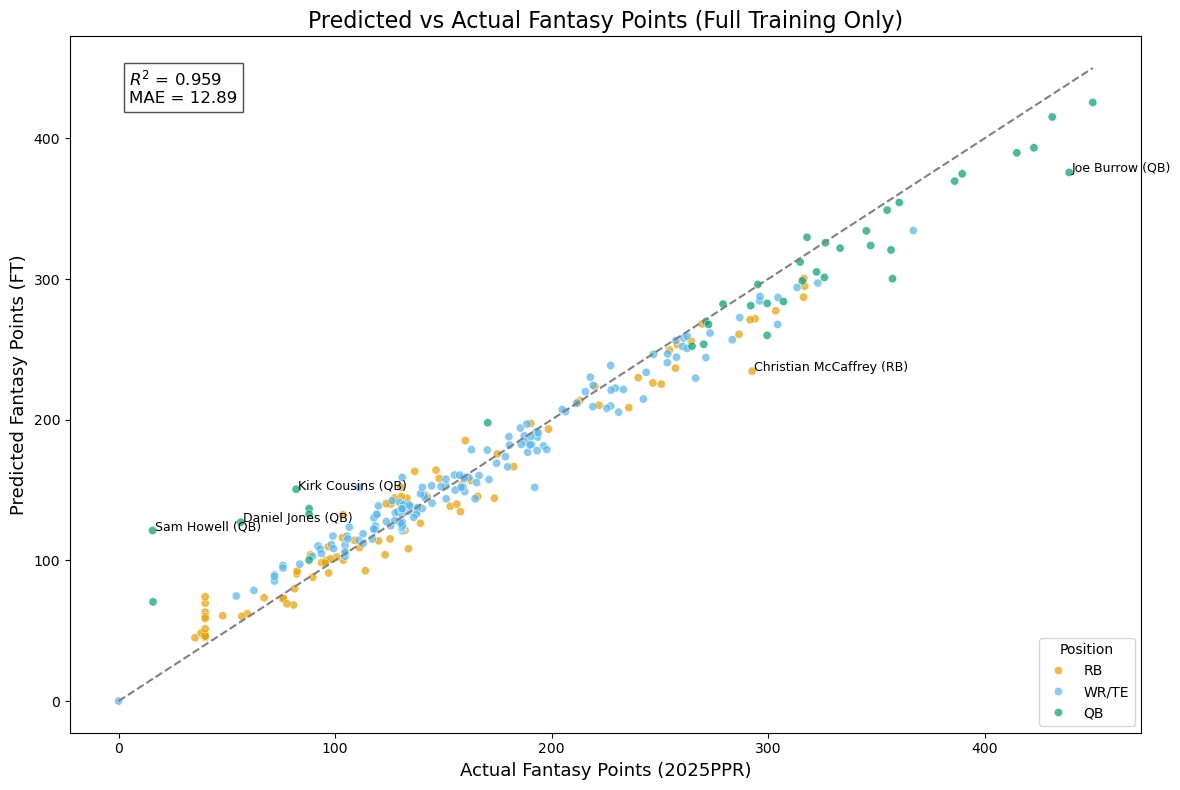

In [100]:
# Filter for Full Training-only data
ft_only = all_predictions[all_predictions['Data Split'] == 'FullTrain'].copy()

# Calculate Full Training metrics
r2_ft = r2_score(ft_only['2025PPR'], ft_only['Predicted Fantasy Points'])
mae_ft = mean_absolute_error(ft_only['2025PPR'], ft_only['Predicted Fantasy Points'])

# Calculate residuals
ft_only['Residual_FT'] = np.abs(ft_only['2025PPR'] - ft_only['Predicted Fantasy Points'])

# Get top 5 residual outliers
top_outliers_ft = ft_only.nlargest(5, 'Residual_FT')

# Colorblind-friendly palette for fantasy positions
color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'TE': '#F0E442',   # yellow
    'QB': '#009E73',  # green
}

# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=ft_only,
    x='2025PPR',
    y='Predicted Fantasy Points',
    hue='FantPos',
    palette=color_palette,
    alpha=0.7
)

# Diagonal reference line
min_val = min(ft_only['2025PPR'].min(), ft_only['Predicted Fantasy Points'].min())
max_val = max(ft_only['2025PPR'].max(), ft_only['Predicted Fantasy Points'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top 5 outliers
for _, row in top_outliers_ft.iterrows():
    plt.text(row['2025PPR'] + 1, row['Predicted Fantasy Points'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Fantasy Points (Full Training Only)', fontsize=16)
plt.xlabel('Actual Fantasy Points (2025PPR)', fontsize=13)
plt.ylabel('Predicted Fantasy Points (FT)', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2_ft:.3f}\nMAE = {mae_ft:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

# Legend and layout
plt.legend(title='Position', loc='lower right')
plt.tight_layout()
plt.show()

In [104]:
# Top 10 overvalued players (Predicted > Actual)
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)

print("Most Overvalued Fantasy Players:")
print(overvalued[['Player', 'FantPos', 'Data Split', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Overvalued Fantasy Players:
                Player FantPos Data Split  2025PPR  Predicted Fantasy Points  \
28          Sam Howell      QB   CrossVal     15.7                    286.70   
23        Kirk Cousins      QB   CrossVal     82.0                    274.50   
29     Aidan O'Connell      QB   CrossVal     15.9                    204.13   
19          Will Levis      QB   CrossVal     88.0                    265.01   
20        Daniel Jones      QB   CrossVal     56.4                    211.83   
25      Deshaun Watson      QB   CrossVal     88.0                    194.54   
66          Sam Howell      QB  FullTrain     15.7                    121.21   
45  Alexander Mattison      RB   CrossVal     40.0                    139.66   
15        Keenan Allen   WR/TE   CrossVal    131.0                    225.43   
37        Tyler Shough      QB   CrossVal    170.5                    264.70   

    ValuationDiff  
28         271.00  
23         192.50  
29         188.23  
19    

In [106]:
# Top 10 undervalued players (Actual > Predicted)
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)

print("Most Undervalued Fantasy Players:")
print(undervalued[['Player', 'FantPos', 'Data Split', '2025PPR', 'Predicted Fantasy Points', 'ValuationDiff']])

Most Undervalued Fantasy Players:
                 Player FantPos Data Split  2025PPR  Predicted Fantasy Points  \
6            Joe Burrow      QB   CrossVal    439.1                    232.12   
0   Christian McCaffrey      RB   CrossVal    292.6                    116.06   
1           Jalen Hurts      QB   CrossVal    422.8                    262.09   
2         Lamar Jackson      QB   CrossVal    450.0                    295.60   
0            Josh Allen      QB   CrossVal    431.3                    291.87   
27        Justin Fields      QB   CrossVal    356.8                    242.41   
10       Jayden Daniels      QB   CrossVal    414.9                    311.50   
31          Rashee Rice   WR/TE   CrossVal    266.5                    163.80   
34    Michael Penix Jr.      QB   CrossVal    299.6                    197.26   
3          Dak Prescott      QB   CrossVal    357.5                    262.82   

    ValuationDiff  
6         -206.98  
0         -176.54  
1         -160